# One_sentiment_analysis_model

### Exploração e limpeza dos dados (EDA)

In [ ]:
# TODO
# dataset inicial? https://www.kaggle.com/datasets/augustop/portuguese-tweets-for-sentiment-analysis/data
!pip install kagglehub[pandas-datasets]

In [ ]:
!pip install emoji

In [78]:
import kagglehub as kh
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji

In [79]:
path = kh.dataset_download(
    "augustop/portuguese-tweets-for-sentiment-analysis"
)

Using Colab cache for faster access to the 'portuguese-tweets-for-sentiment-analysis' dataset.


In [80]:
print(path)

/kaggle/input/portuguese-tweets-for-sentiment-analysis


In [81]:
!ls $path

NoThemeTweets.csv  trainingdatasets	  TweetsNeutralNews.csv
testdatasets	   TrainingDatasets	  TweetsWithTheme.csv
TestDatasets	   TweetsNeutralHash.csv


In [82]:
file_path = os.path.join(path, "NoThemeTweets.csv")
df = pd.read_csv(file_path)

df.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1031761728445530112,@Tixaa23 14 para eu ir :),Tue Aug 21 04:35:39 +0000 2018,Positivo,:)
1,1031761040462278656,@drexalvarez O meu like eu já dei na época :),Tue Aug 21 04:32:55 +0000 2018,Positivo,:)
2,1031760962372689920,Eu só queria conseguir comer alguma coisa pra ...,Tue Aug 21 04:32:37 +0000 2018,Positivo,:)
3,1031760948250456066,:D que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,Positivo,:)
4,1031760895985246208,"@Primo_Resmungao Pq da pr jeito!!é uma ""oferta...",Tue Aug 21 04:32:21 +0000 2018,Positivo,:)


In [83]:
df.shape

(785814, 5)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785814 entries, 0 to 785813
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          785814 non-null  int64 
 1   tweet_text  785814 non-null  object
 2   tweet_date  785814 non-null  object
 3   sentiment   785814 non-null  object
 4   query_used  785814 non-null  object
dtypes: int64(1), object(4)
memory usage: 30.0+ MB


In [85]:
df.describe(include="all")

,id,tweet_text,tweet_date,sentiment,query_used
count,7.858140e+05,785814,785814,785814,785814
unique,NaN,776753,626845,2,2
top,NaN,Bom dia :),Thu Sep 13 14:12:25 +0000 2018,Negativo,:(
freq,NaN,227,10,522707,522707
mean,1.038515e+18,NaN,NaN,NaN,NaN
std,5.528717e+15,NaN,NaN,NaN,NaN
min,1.029536e+18,NaN,NaN,NaN,NaN
25%,1.032427e+18,NaN,NaN,NaN,NaN
50%,1.039270e+18,NaN,NaN,NaN,NaN
75%,1.042934e+18,NaN,NaN,NaN,NaN


In [86]:
df.sentiment.value_counts()

,count
sentiment,
Negativo,522707
Positivo,263107


In [87]:
df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
Negativo,0.665179
Positivo,0.334821


In [88]:
df.tweet_text.sample(20)

,tweet_text
765409,tipo dois dias p fazer anos :)
778564,eu só queria achar meus documentos :(
252170,Vishhh..... N gosto de ver vc triste no tt :((...
219635,@PaiBoninho o sonho durou pouco :( https://t.c...
474939,@eduardavpb Ê porra acabei de ver q vc é do PR...
683467,@Joanaribeiro03 Eu sei :))
589400,só queria dizer que estou triste por não conse...
97106,@cabeyodrunk_ infelizmente nao é gente :( http...
308630,eu pedi tanto thaina pra baixar ff meus amigos...
429361,@CentralDeFasLS @meuguialrds Nunca mais tinha ...


In [89]:
df['text_len'] = df.tweet_text.astype(str).apply(len)

In [90]:
df.text_len.describe()

,text_len
count,785814.000000
mean,75.575976
std,54.942813
min,6.000000
25%,38.000000
50%,58.000000
75%,94.000000
max,751.000000


In [91]:
df[df['id'] == 1031760615268929536]

,id,tweet_text,tweet_date,sentiment,query_used,text_len
11,1031760615268929536,@youngsnowblood @thegr8angelica a para vc q é ...,Tue Aug 21 04:31:14 +0000 2018,Positivo,:),88


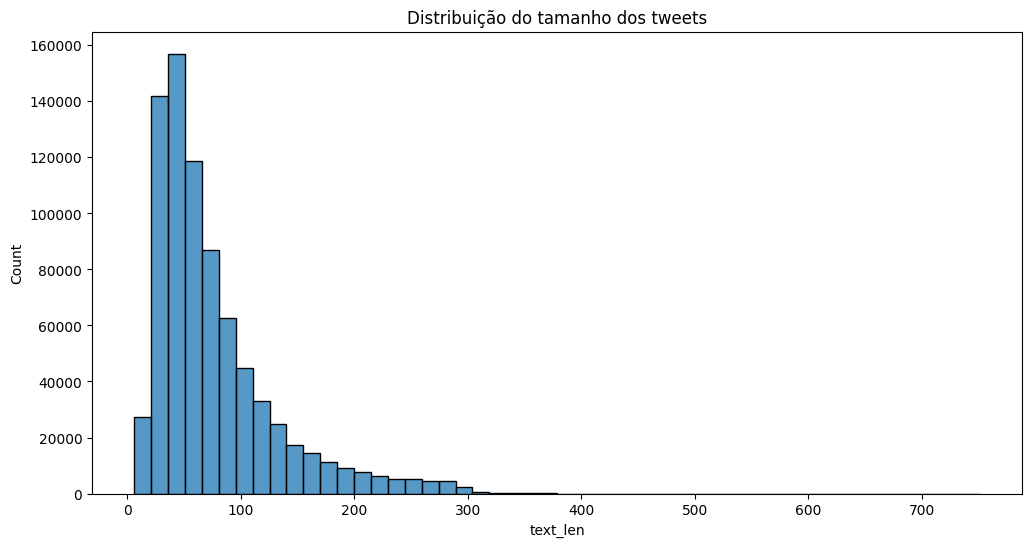

In [92]:
plt.figure(figsize=(12, 6))
sns.histplot(df.text_len, bins=50)
plt.title("Distribuição do tamanho dos tweets")
plt.show()

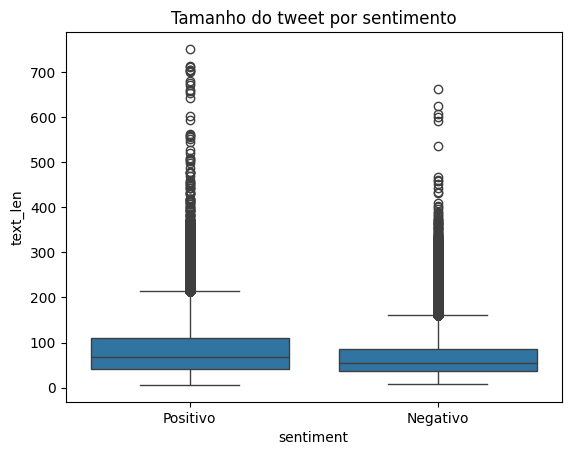

In [93]:
sns.boxplot(x='sentiment', y='text_len', data=df)
plt.title("Tamanho do tweet por sentimento")
plt.show()

In [94]:
df.duplicated().sum()

np.int64(0)

### ETL

In [95]:
df['tweet_date'] = pd.to_datetime(df['tweet_date'], errors='coerce')

/tmp/ipython-input-4115413624.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tweet_date'] = pd.to_datetime(df['tweet_date'], errors='coerce')


In [96]:
df.tweet_date.isna().sum()

np.int64(0)

In [97]:
df['sentiment'] = df.sentiment.str.lower()
df.sentiment.value_counts(normalize=True)

,proportion
sentiment,
negativo,0.665179
positivo,0.334821


In [98]:
df['sentiment_label'] = df.sentiment.map({
    'positivo': 1,
    'negativo': 0
})

In [99]:
# emojis nos tweets
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # links
    text = re.sub(r'@\w+', '', text)            # menções
    text = re.sub(r'#\w+', '', text)            # hashtags
    text = re.sub(r'rt\s+', '', text)           # RT
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['tweet_clean'] = df['tweet_text'].astype(str).apply(clean_tweet)

In [101]:
# converter emoji em texto
df['tweet_clean'] = df['tweet_clean'].apply(
    lambda x: emoji.demojize(x, delimiters=(" ", " "))
)

In [123]:
df[df['id'] == 1031760615268929536]

,id,tweet_text,tweet_date,sentiment,query_used,text_len,sentiment_label,tweet_clean,text_len_clean
11,1031760615268929536,@youngsnowblood @thegr8angelica a para vc q é ...,2018-08-21 04:31:14+00:00,positivo,:),88,1,"a para vc q é heart_suit heart_suit mt obg,...",76


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785814 entries, 0 to 785813
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   id               785814 non-null  int64              
 1   tweet_text       785814 non-null  object             
 2   tweet_date       785814 non-null  datetime64[ns, UTC]
 3   sentiment        785814 non-null  object             
 4   query_used       785814 non-null  object             
 5   text_len         785814 non-null  int64              
 6   sentiment_label  785814 non-null  int64              
 7   tweet_clean      785814 non-null  object             
 8   text_len_clean   785814 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(4), object(4)
memory usage: 54.0+ MB


In [103]:
df['text_len_clean'] = df.tweet_clean.apply(len)

In [104]:
df = df[df['tweet_clean'].str.len() > 0]

In [117]:
df_final = df[[
    'tweet_clean',
    'sentiment_label',
    'tweet_date',
    'query_used',
    'text_len_clean'
]]

In [118]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785814 entries, 0 to 785813
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   tweet_clean      785814 non-null  object             
 1   sentiment_label  785814 non-null  int64              
 2   tweet_date       785814 non-null  datetime64[ns, UTC]
 3   query_used       785814 non-null  object             
 4   text_len_clean   785814 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 30.0+ MB


In [124]:
df_final.to_csv('tweets_sentiment.csv', index=False)

In [119]:
df_final.head()

,tweet_clean,sentiment_label,tweet_date,query_used,text_len_clean
0,14 para eu ir :),1,2018-08-21 04:35:39+00:00,:),16
1,o meu like eu já dei na época :),1,2018-08-21 04:32:55+00:00,:),32
2,eu só queria conseguir comer alguma coisa pra ...,1,2018-08-21 04:32:37+00:00,:),61
3,:d que lindo dia !,1,2018-08-21 04:32:33+00:00,:),18
4,"pq da pr jeito!!é uma ""oferta"", ha q aproveita...",1,2018-08-21 04:32:21+00:00,:),51


### Transformação dos textos em números com TF-IDF

In [ ]:
# TODO

### Treinamento de modelo supervisionado (ex.: Logistic Regression, Naive Bayes)

In [ ]:
# TODO

### Métricas de desempenho (Acurácia, Precisão, Recall, F1-score)

In [ ]:
# TODO

### Serialização do modelo (joblib/pickle)

In [ ]:
# TODO